In [13]:
import os
import glob
import json
from datetime import datetime
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from scipy.stats import binom
import pandas as pd
import pingouin as pg
import re

folder_path = "study-data"

In [14]:
rows = []

# Loop through all jsonl files
for jsonl_path in glob.glob(os.path.join(folder_path, "*.jsonl")):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue

            try:
                record = json.loads(line)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON on line {line_num} in file {jsonl_path}")
                continue

            user_answer = record.get("user_answer", {})
            pid = record.get("PID", None)

            # Unpack user_answer entries
            for question_key, value in user_answer.items():
                if not isinstance(value, list) or len(value) != 2:
                    print(f"Unexpected format for {question_key} in file {jsonl_path}")
                    continue

                timestamp, answer = value

                rows.append({
                    "question": question_key,
                    "timestamp": timestamp,
                    "answer": answer,
                    "PID": pid,
                    "source_file": os.path.basename(jsonl_path)
                })

# Convert list of dicts to DataFrame
data = pd.DataFrame(rows)

# Optional: Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Display first few rows
data.head()

,question,timestamp,answer,PID,source_file
0,7first_choiceC3,2025-07-17 15:00:19.598041,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
1,7second_choiceC3,2025-07-17 15:00:16.851518,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
2,7third_choiceC3,2025-07-17 15:00:27.078233,Tell the patient about their condition.,3,66bfdc082ffe8d45b60263a6.jsonl
3,1first_choiceC3,2025-07-17 15:01:08.913367,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl
4,1second_choiceC3,2025-07-17 15:01:28.387955,"[5000, 5000, 0]",3,66bfdc082ffe8d45b60263a6.jsonl


[1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1]
ShapiroResult(statistic=np.float64(0.7327035797764425), pvalue=np.float64(2.813338074885512e-05))
0.7327035797764425


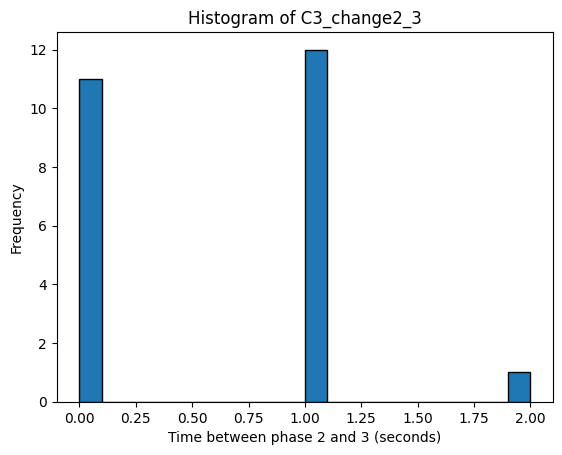

In [15]:
participant = []
conditions = []
time = []
C1_time2_3 = []
C2_time2_3 = []
C3_time2_3 = []

C1_change2_3 = []
C2_change2_3 = []
C3_change2_3 = []


for src_file in data['source_file'].unique():
    C1_counter = 0
    C2_counter = 0
    C3_counter = 0

    for q in range(1, 13):
        for condition in range(1, 4):
            first_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}first_choiceC{condition}")]
            second_choice = data.loc[(data['source_file'] == src_file) & (data['question'] == f"{q}second_choiceC{condition}")]
            third_choice = data.loc[(data['source_file'] == src_file) & (data['question']== f"{q}third_choiceC{condition}")]

            if second_choice.shape[0] < 1 or third_choice.shape[0] < 1:
                continue
        
            t1 = first_choice.iloc[0]['timestamp']
            t2 = second_choice.iloc[0]['timestamp']
            t3 = third_choice.iloc[0]['timestamp']
            if pd.notnull(t1) and pd.notnull(t2):
                participant.append(src_file)
                conditions.append(f"C{condition}")
                # time taken between phase 3 and phase 2 CHANGE HERE TO CALCULATE TIME BETWEEN phase 1 and phase 2
                if condition == 1 and (second_choice.iloc[0]['answer']!= third_choice.iloc[0]['answer']):
                    C1_counter +=1
                if condition == 2 and (second_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C2_counter +=1
                if condition == 3 and (second_choice.iloc[0]['answer'] != third_choice.iloc[0]['answer']):
                    C3_counter +=1

    C1_change2_3.append(C1_counter)
    C2_change2_3.append(C2_counter)
    C3_change2_3.append(C3_counter)

shapiro_test = stats.shapiro(C3_change2_3)
print(C3_change2_3)
print(shapiro_test)
print(shapiro_test.statistic)

plt.hist(C3_change2_3, bins=20, edgecolor='black')
plt.xlabel('Time between phase 2 and 3 (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of C3_change2_3')
plt.show() 
